In [18]:
using DelimitedFiles
using Statistics
using LinearAlgebra
using Plots

# Card (1993): Returns to Schooling

## Quantile Regression

Card (1993) presents an analysis of returns to schooling
using the data from the National Longitudinal Survey of Young Men,
for those interviewed in 1976. Card presents OLS and instrumental
variables estimates for a number of specifications, using college
proximity as an instrument for years of education, and age as an instrument
for experience. Here, we work with the simple model from column (1)
of Card's Table 2. Let's consider estimation of conditional quantiles
for the model. The model is 
\begin{align*}
Q_{\ln W|X}(\tau) & =\beta_{0}(\tau)+\beta_{EDUC}(\tau)EDUC+\beta_{X}(\tau)EXP+\beta_{EXP^{2}}(\tau)\frac{EXP^{2}}{100}\\
 & +\beta_{BLACK}(\tau)BLACK+\beta_{SMSA}(\tau)SMSA+\beta_{SOUTH}(\tau)SOUTH\\
 & \equiv X\beta(\tau)
\end{align*}

- the dependent variable $\ln W$ is log hourly earnings (in cents)
- the regressors are years of education (EDUC), experience (EXP), experience
squared divided by 100, a black indicator (BLACK), a metropolitan
area indicator (SMSA), and a South indicator (SOUTH).

In [19]:
data = readdlm("../data/card.data")
LNW = data[:,1]
EDUC = data[:,2]
EDUC = EDUC .- mean(EDUC)
EXPER = data[:,3]
EXPER = EXPER .- mean(EXPER)
BLACK = data[:,4]
SMSA = data[:,5]
SOUTH = data[:,6]
NEARC4 = data[:,7]
AGE = data[:,8]
EXPSQ = (EXPER.^2.0);

In [9]:
constant = ones(size(LNW))
LNW = data[:,1]
Z = [constant NEARC4 AGE AGE.^2 BLACK SMSA SOUTH]
X = [constant EDUC EXPER EXPSQ BLACK SMSA SOUTH];

When all variables are exogenous, then quantile regression estimates may be obtained by standard methods.


QR results for EDUC are below. (Test this at home)

![alt text](../images/QReduc.png)



Note that the QR results are pretty close to the OLS results, for
all quantiles, and there's no clear pattern of the effect of education
differing across quantiles. 


The effect of an additional year of education on earnings is about
7-8%, all across the distribution.

## Quantile IV Regression and Bayesian GMM vis MCMC

When education and experience are treated as endogenous, we use proximity
to an accredited four year college (NEARC4) as an instrumental variable.
EXPER is defined as $EXPER = AGE-EDUC-6$, so if EDUC is endogenous,
so is EXPER. We use AGE as an instrument for EXPER. 

We may use an instrumental variables version of quantile regression,
due to Chernozhukov and Hansen (2005). They show that the moment conditions
$$
m_{n}(\theta)=\frac{1}{n}\sum_{i=1}^{n}Z_{i}\left(\tau-1\left[y_{i}\le X_{i}\beta(\tau)\right]\right)
$$
(where $\theta=\beta(\tau))$ have expectation zero at the true parameter
values, and thus can be used for GMM estimation. 

We can show that, at the true parameter values 
$$
\sqrt{n}m_{n}(\theta_{0})\rightarrow^{d}N(0,(\tau-\tau^{2})Q_{Z})
$$
so an estimate of the efficient weight matrix is the inverse of $\hat{\Sigma}=\frac{(\tau-\tau^{2})}{n}\sum_{i}Z_{i}Z_{i}^{\prime}.$ 

The problem is that these moment conditions are discontinuous functions
of the parameters, due to the indicator function, so gradient-based
optimization methods will not work for computing the GMM estimates.

To deal with this problem, we can consider using the MCMC methods
proposed by Chernozhukov and Hong (2003) to compute a Bayesian version
of the GMM estimator. 

This estimator works with the asymptotic distribution of the moment
conditions to define the likelihood used in MCMC, rather than the
full sample likelihood function, but otherwise, it is standard MCMC.
- the use of moment conditions is a dimension reducing operation: the
full sample likelihood requires knowing the distribution of $n$ (growing
with the sample size) random variables, while the use of moment conditions
and their asymptotic distribution only requires knowing the (asymptotic)
distribution of $G$ (fixed and finite) random variables
- thus, GMM is like a limited information ML estimator, with the asymptotic
distribution substituting the actual small sample distribution.

In [20]:
# the moments
function moments(beta::Array{Float64,1}, y::Array{Float64,1}, x::Array{Float64,2},
    z::Array{Float64,2}, tau::Float64)
    m = mean(z.*(tau .- (y .<= x*beta)),dims=1)
end

function likelihood(θ, y, x, z, τ, Σinv)
    m = moments(θ, y, x, z, τ)
    n = size(x,1)
    lnL = log(sqrt(det(Σinv))) + (-0.5*n*m*Σinv*m')[1]
end

function prior(theta)
    lb = [4.0, 0.0, 0.0, -0.1, -0.5, -0.5,  -0.5]
    ub = [9.0, 0.5, 0.2, 0.0, 0.5, 0.5,  0.5]
    a = 0.0
    if(all((theta .>= lb) .& (theta .<= ub)))
        a = 1.0
    end    
    return a
end

function proposal(current, tuning)
    i = rand(1:size(current,1))
    trial = copy(current)
    #trial[i] = trial[i] + tuning[i]*randn()
    trial = trial + tuning.*randn(size(trial))
    return trial
end

function proposal2(current, cholV)
    trial = copy(current)
    trial = trial + cholV'*randn(size(trial))
    return trial
end

function mcmc(θ, reps::Int64, burnin::Int64, Prior::Function, lnL::Function, Proposal::Function)
    lnLθ = lnL(θ)
    chain = zeros(reps, size(θ,1)+1)
    for rep = 1:burnin+reps
        θᵗ = Proposal(θ) # new trial value
        pt = Prior(θᵗ)
        accept = false
        if pt > 0.0
            lnLθᵗ = lnL(θᵗ)
            accept = rand() < exp(lnLθᵗ-lnLθ) * pt/Prior(θ)
            if accept
                θ = θᵗ
                lnLθ = lnLθᵗ 
            end
        end
        if rep > burnin
            chain[rep-burnin,:] = [θ; accept]
        end    
    end
    return chain
end

mcmc (generic function with 1 method)

In [31]:
function dstats(x, rnames="";short=false)
    k = size(x,2)
    if rnames==""
        rnames = 1:k
        rnames = rnames'
    end
    m = mean(x,dims=1)
    mm = median(x,dims=1)
    s = std(x,dims=1)
    sk = m-m
    kt = m-m
    mn = minimum(x,dims=1)
    mx = maximum(x,dims=1)
    q05 = fill(0.0,k)
    q25 = fill(0.0,k)
    q75 = fill(0.0,k)
    q95 = fill(0.0,k)
    if short == false
        for i = 1:size(x,2) q05[i], q25[i], q75[i],q95[i] = quantile(x[:,i], [0.05,0.25,0.75,0.95]) end
        cnames = ["  mean", " median","  std", "IQR", "min", "max", "q05", "q95"]
        stats = [m' mm' s' (q75-q25) mn' mx' q05 q95] 
    else
        cnames = ["  mean", " median", "  std", "min", "max"]
        stats = [m' mm' s' mn' mx'] 
    end
    return stats
end

dstats (generic function with 2 methods)

In [32]:
n = size(LNW,1)
mcmcreps = 100000
burnin = 10000
basetuning = [0.1, 0.05, 0.03, 0.005, 0.3, 0.2, 0.2]

scale = 0.1 # higher for higher quantiles
tuning = scale*basetuning
EducEffect = zeros(9,3)
Constant = zeros(9,3)
for i = 1:9
    τ = round(i/10,digits=1)
    Σ = τ*(1.0-τ)*Z'Z/n
    Σinv = inv(Σ)
    θ = X\LNW  # OLS start values
    # to do ordinary QR via MCMC, set Z=X (just to verify that MCMC works!)
    lnL = θ -> likelihood(θ, LNW, X, Z, τ, Σinv)
    Proposal = θ -> proposal(θ, tuning)
    Prior = θ -> prior(θ)
    chain = mcmc(θ, mcmcreps, burnin, Prior, lnL, Proposal)
    V = cov(chain[:,1:end-1])
    d = dstats(chain)
    Constant[i,:] = d[1,[1,7,8]] # save posterior mean, 5% and 95% quantile
    EducEffect[i,:] = d[2,[1,7,8]] # save posterior mean, 5% and 95% quantile
end

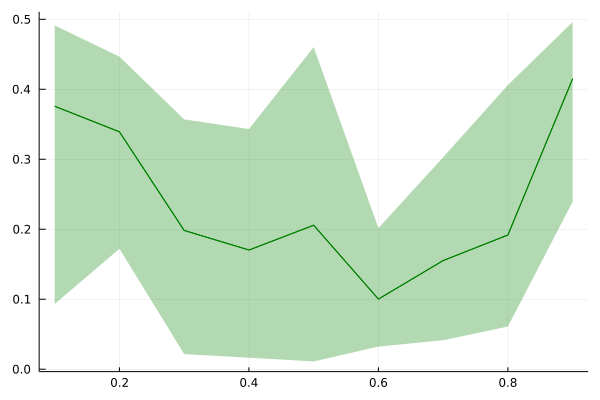

In [33]:
τ = (1:9)/10
plot(reuse=false)
educ = EducEffect[:,1]
lb = EducEffect[:,2]
ub = EducEffect[:,3]
plot!(τ, [educ educ], fillrange=[lb ub], fillalpha=0.3, c=:green, legend=:none)

We can see that the IVQR results are substantially different from
the ordinary QR results. Compare the two graphs in this document.
- The effect of education, according to the IVQR results, is substantially
larger, for all quantiles, with an additional year of education increasing
all quantiles, except the 40th, by more than 20\%. This is good news
for the people in the U.S. that have to take out enormous student
loans. Given the cost of college tuition in the U.S., the miserable
7\% return that OLS and ordinary QR find would probably not be enough
to induce people to take out loans. So, we have external reasons to
believe that this higher number may be more realistic. It would be
interesting to study the evolution of returns over time, and compare
them to the cost of education.
- There is a U shape, with a greater effect at the lower and higher
quantiles. 
- The confidence bands are broader for the IV version, which is to be
expected. This is similar to what happens with ordinary IV and OLS.

The results are quite similar to those of Chernozhukov and Hansen (2006),
who estimate a similar model using the Angrist and Krueger (1991) data
(this is the influential paper that used quarter of birth as an instrument
for education).
